In [1]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import Linear 

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
import random
import scipy.stats

%matplotlib inline

In [2]:


def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)


In [3]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta

        Args:
        ----------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                输出特征维度
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'




In [166]:
class GcnNet(nn.Module):
    """
    定义一个 GraphConvolution的模型
    """
    def __init__(self, input_dim=1433):
        super(GcnNet, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 940)
        self.gcn2 = GraphConvolution(940,400)
        self.gcn3 = GraphConvolution(400,150 )
        self.gcn4 = GraphConvolution(150, 36)
        self.gcn5 = GraphConvolution(36, 150)
        self.gcn6 = GraphConvolution(150, 400)
        self.gcn7 = GraphConvolution(400, 940)
        self.gcn8 = GraphConvolution(940, input_dim)
        
        self.h1=None
        self.h2=None
        self.h3=None
        self.h4=None
        self.h5=None
        self.h6=None
        self.h7=None
        self.h8=None
    
    def forward(self, adjacency, feature):
        self.h1 = F.relu(self.gcn1(adjacency, feature))
        self.h1 = F.normalize(self.h1)
        
        self.h2  = F.sigmoid(self.gcn2(adjacency, self.h1))
        self.h2 = F.normalize(self.h2)
        
        self.h3 = F.relu(self.gcn3(adjacency, self.h2))
        self.h3 = F.normalize(self.h3)
        
        self.h4  = F.sigmoid(self.gcn4(adjacency, self.h3))
        self.h4 = F.normalize(self.h4)
        
        self.h5  = F.relu(self.gcn5(adjacency, self.h4))
        self.h5 = F.normalize(self.h5)
        
        self.h6  = F.sigmoid(self.gcn6(adjacency, self.h5))
        self.h6 = F.normalize(self.h6)
        
        self.h7  = F.relu(self.gcn7(adjacency, self.h6))
        self.h7 = F.normalize(self.h7)
        
        self.h8  = self.gcn8(adjacency, self.h7)
#         self.h8 = F.normalize(self.h8)
        return  self.h8


In [167]:
# 超参数定义
LEARNING_RATE = 0.001
WEIGHT_DACAY = 1e-4
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [168]:
node_feature = np.load('../data/X_np/X.npy')
node_feature2= np.zeros(shape=[850,1879],dtype=np.float32)
node_feature2[:,0:256]=node_feature[:, 0:256]

for i in range(0,850):
    for j in range(0,1623):
        try:
            node_feature2[i][j+256]=max(node_feature[i,256+5*j: 256+j*5+5]) 
        except:
            print(j)
            break
            
node_feature2/=node_feature2.sum(1, keepdims=True)   

In [169]:



tensor_x = tensor_from_numpy(node_feature2, DEVICE)
labelList=pd.read_csv('../data/label.csv',header=None)[1]
for i in range(0,len(labelList)):
    labelList[i]+=1




train_mask=[True for i in range(0,850)]
tensor_train_mask = tensor_from_numpy(np.array(train_mask), DEVICE )


adjacency=np.load('../data/A_np/A.npy')

# kmer_dist=np.load('../data/kmer4/kmer_dist.npy')

# 
# for i in range(0,850):
#     for j in range(i+1,850):
#         N_intra=scipy.stats.norm(255.15088262236475, 21380.59836464786).cdf(kmer_dist[i][j])
#         N_inter=scipy.stats.norm(233.925124929788, 18903.327684868505).cdf(kmer_dist[i][j])
#         adjacency[i][j]=N_intra/(N_intra+N_inter)
        
# for i in range(1,850):
#     for j in range(0,i):
#         adjacency[i][j]=kmer_dist[j][i]



        
adjacency=np.eye(adjacency.shape[0])
        
adjacency=adjacency.astype(np.double)
adjacency = sp.csr_matrix(adjacency)
adjacency = sp.coo_matrix(adjacency)
adjacency += sp.eye(adjacency.shape[0])    # 增加自连接
degree = np.array(adjacency.sum(1))
d_hat = sp.diags(np.power(degree, -0.5).flatten())
normalize_adjacency = d_hat.dot(adjacency).dot(d_hat).tocoo()  # 规范化邻接矩阵


#num_nodes, input_dim = node_feature.shape #

num_nodes, input_dim = node_feature2.shape

indices = torch.from_numpy(np.asarray([normalize_adjacency.row, 
                                       normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, 
                                            (num_nodes, num_nodes)).to(DEVICE)

In [170]:
# 模型定义：Model, Loss, Optimizer
model = GcnNet(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

In [171]:
# 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train()
#     train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        # tensor_adjacency 也就是 A 矩阵, tensor_x 也就是 X 矩阵
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
 
    
        criterion=nn.MSELoss(reduction='mean')
        loss = criterion(train_mask_logits, tensor_x)
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
 
        loss_history.append(loss.item())
 
    return loss_history, model.h4


In [184]:
loss,feature_layer = train()
 
print(loss)

C:\Users\Chester_Zhang\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[2.0469340597628616e-05, 2.026006768574007e-05, 1.846560917329043e-05, 1.5896701370365918e-05, 1.351081118627917e-05, 1.1920058568648528e-05, 1.1337535397615284e-05, 1.1633375834207982e-05, 1.2429096386767924e-05, 1.3252993994683493e-05]


In [185]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    

    
    plt.xlabel('Epoch')
    plt.title('Training Loss ')
    plt.show() 

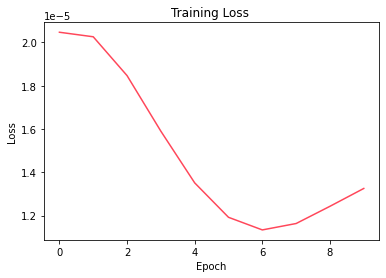

In [186]:
plot_loss_with_acc(loss, [])

In [187]:
feature_np=feature_layer.detach().numpy()
feature_np/=feature_np.sum(1, keepdims=True)


In [188]:
kmeans = KMeans(n_clusters=12,init='k-means++').fit(feature_np)

# y_pred = KMeans(n_clusters=12,init='k-means++').fit_predict(feature_layer.detach().numpy())



In [189]:


def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

print('purity : ',purity_score(labelList,kmeans.labels_ ))
print('ARI : ',adjusted_rand_score(labelList,kmeans.labels_))
print('NMI : ',normalized_mutual_info_score(labelList,kmeans.labels_ ))

purity :  0.7505882352941177
ARI :  0.6117878729409781
NMI :  0.7192358214773148
